# Quick demo of the HealPixRegridder

Work in progress..


In [1]:
# Prerequisites
import numpy as np
from toad import TOAD
from sklearn.cluster import HDBSCAN  # type: ignore
from toad.regridding import HealPixRegridder
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# Dataset contains pre-computed shifts
td = TOAD("test_data/global_mean_summer_tas.nc", log_level="INFO")
td.data = td.data.coarsen(lat=2, lon=2, boundary="trim").reduce(np.mean)

INFO: Logging level set to INFO


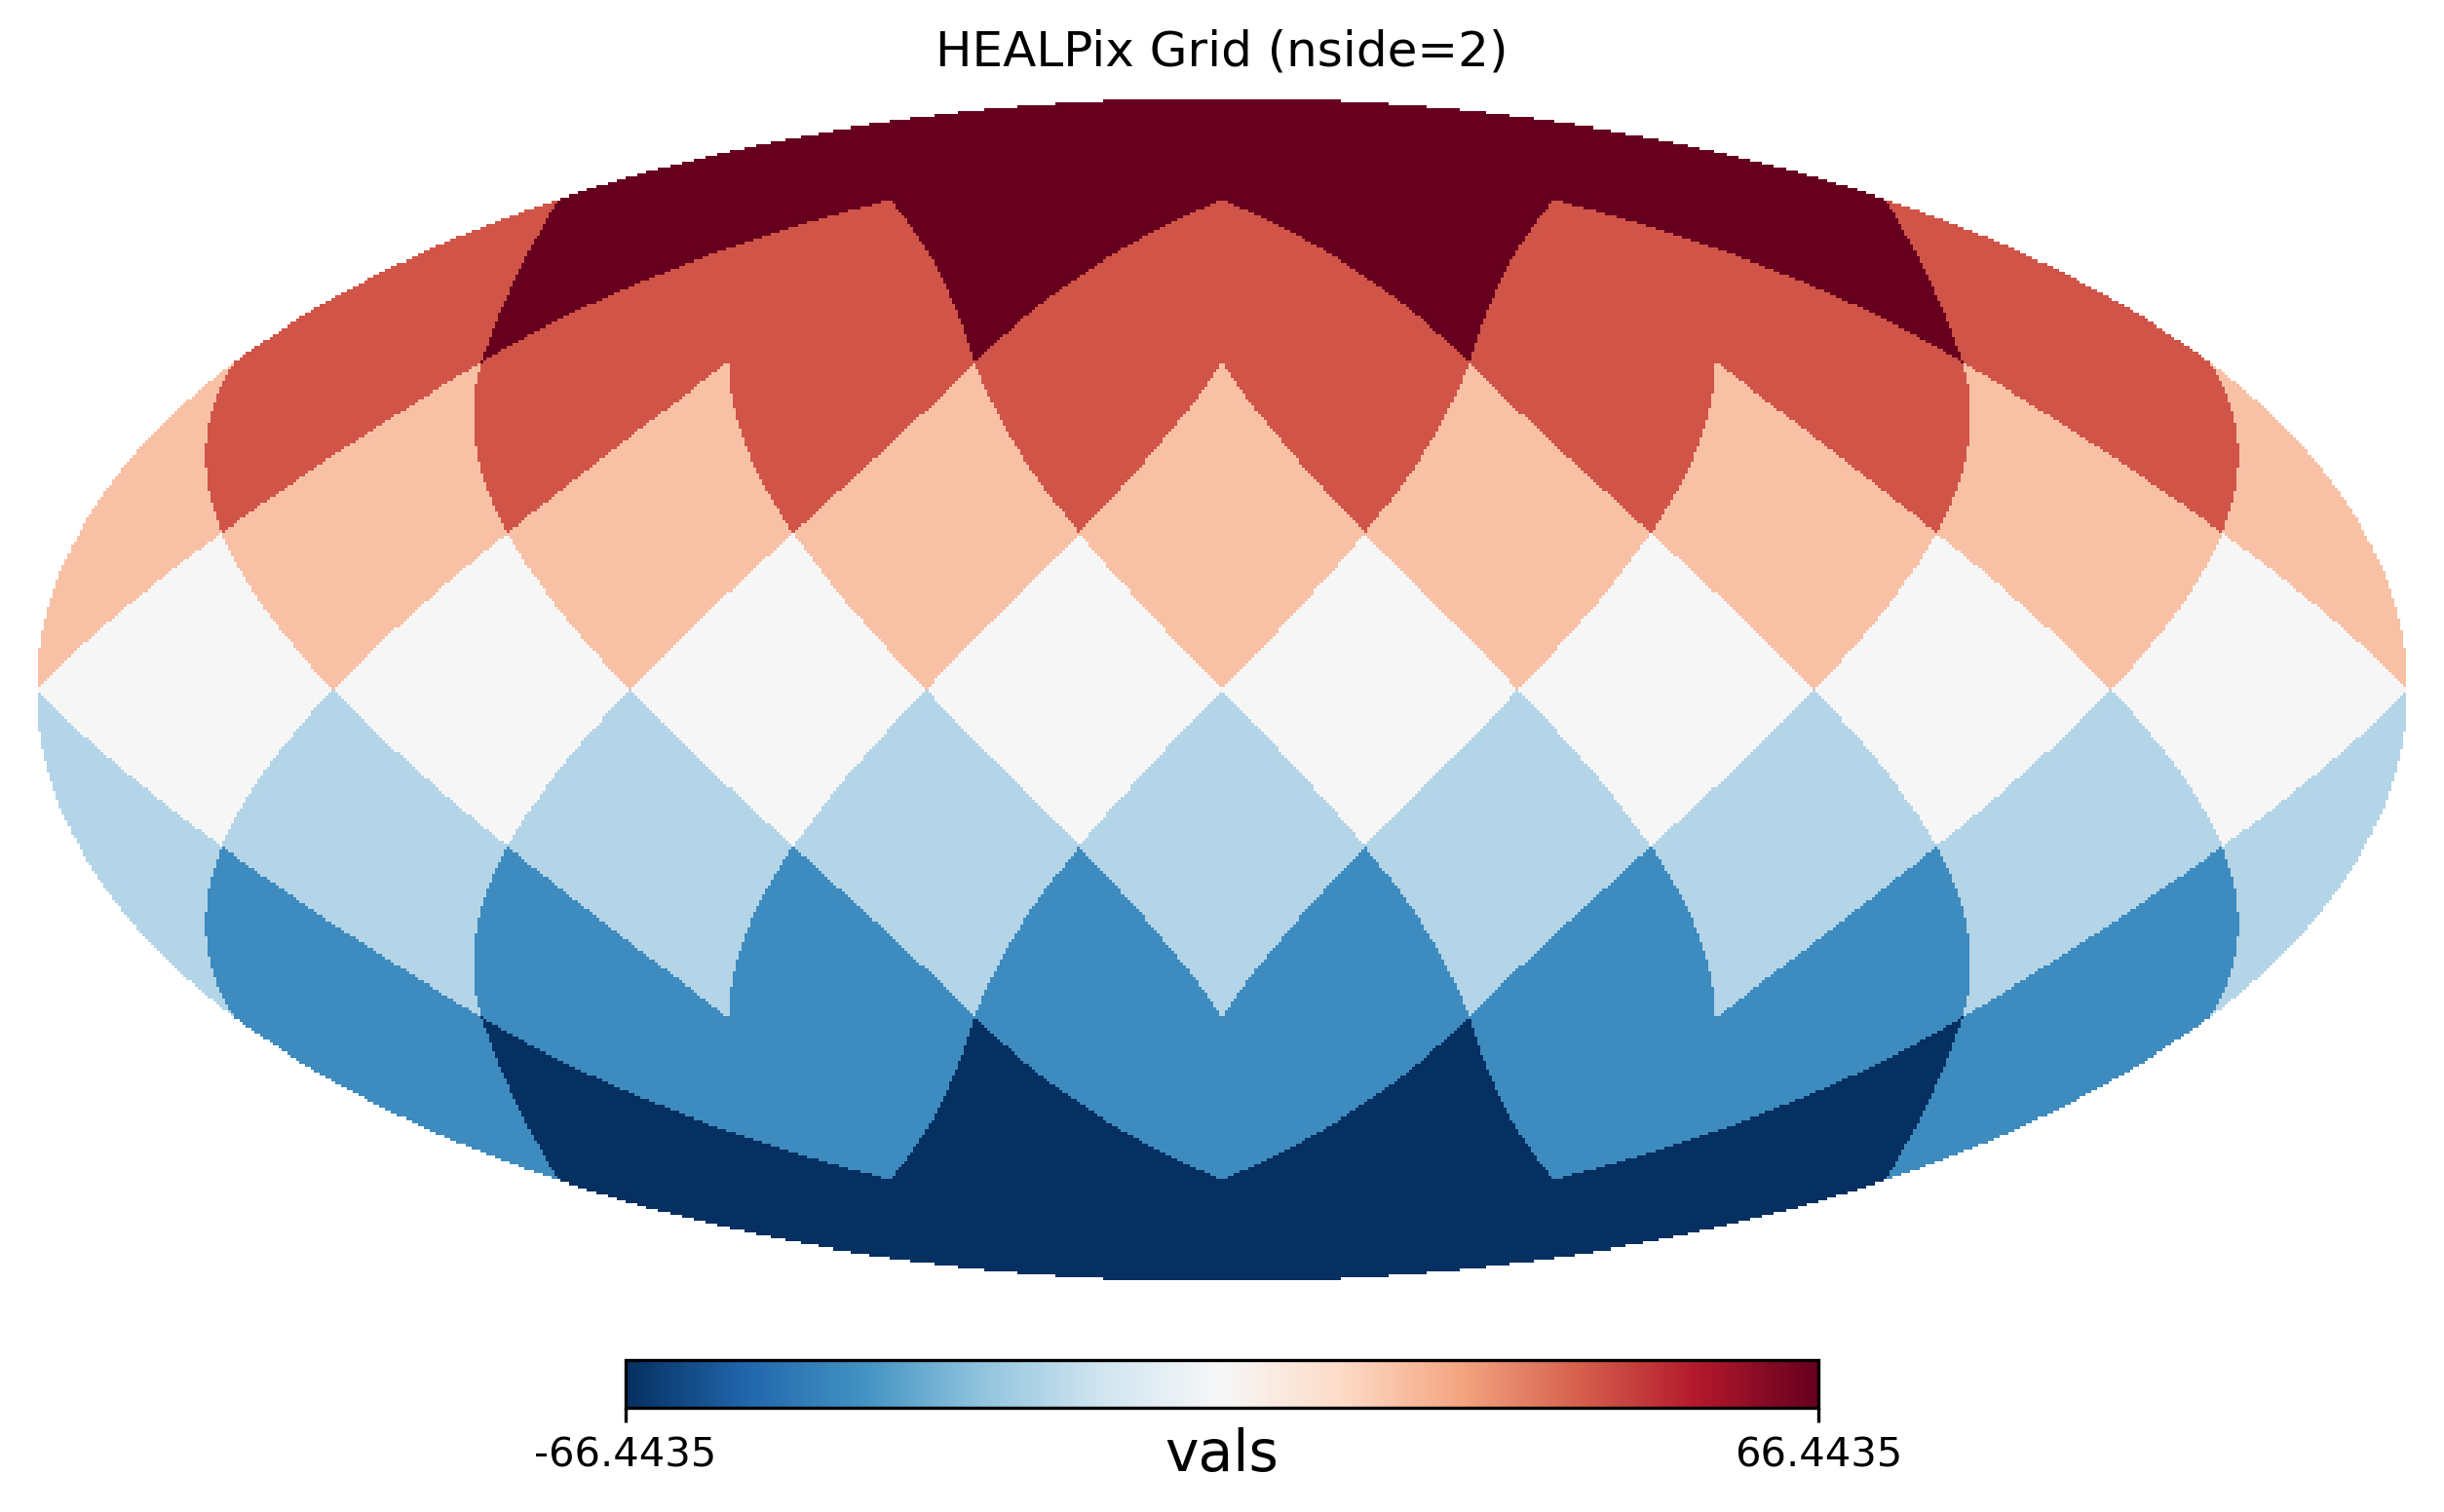

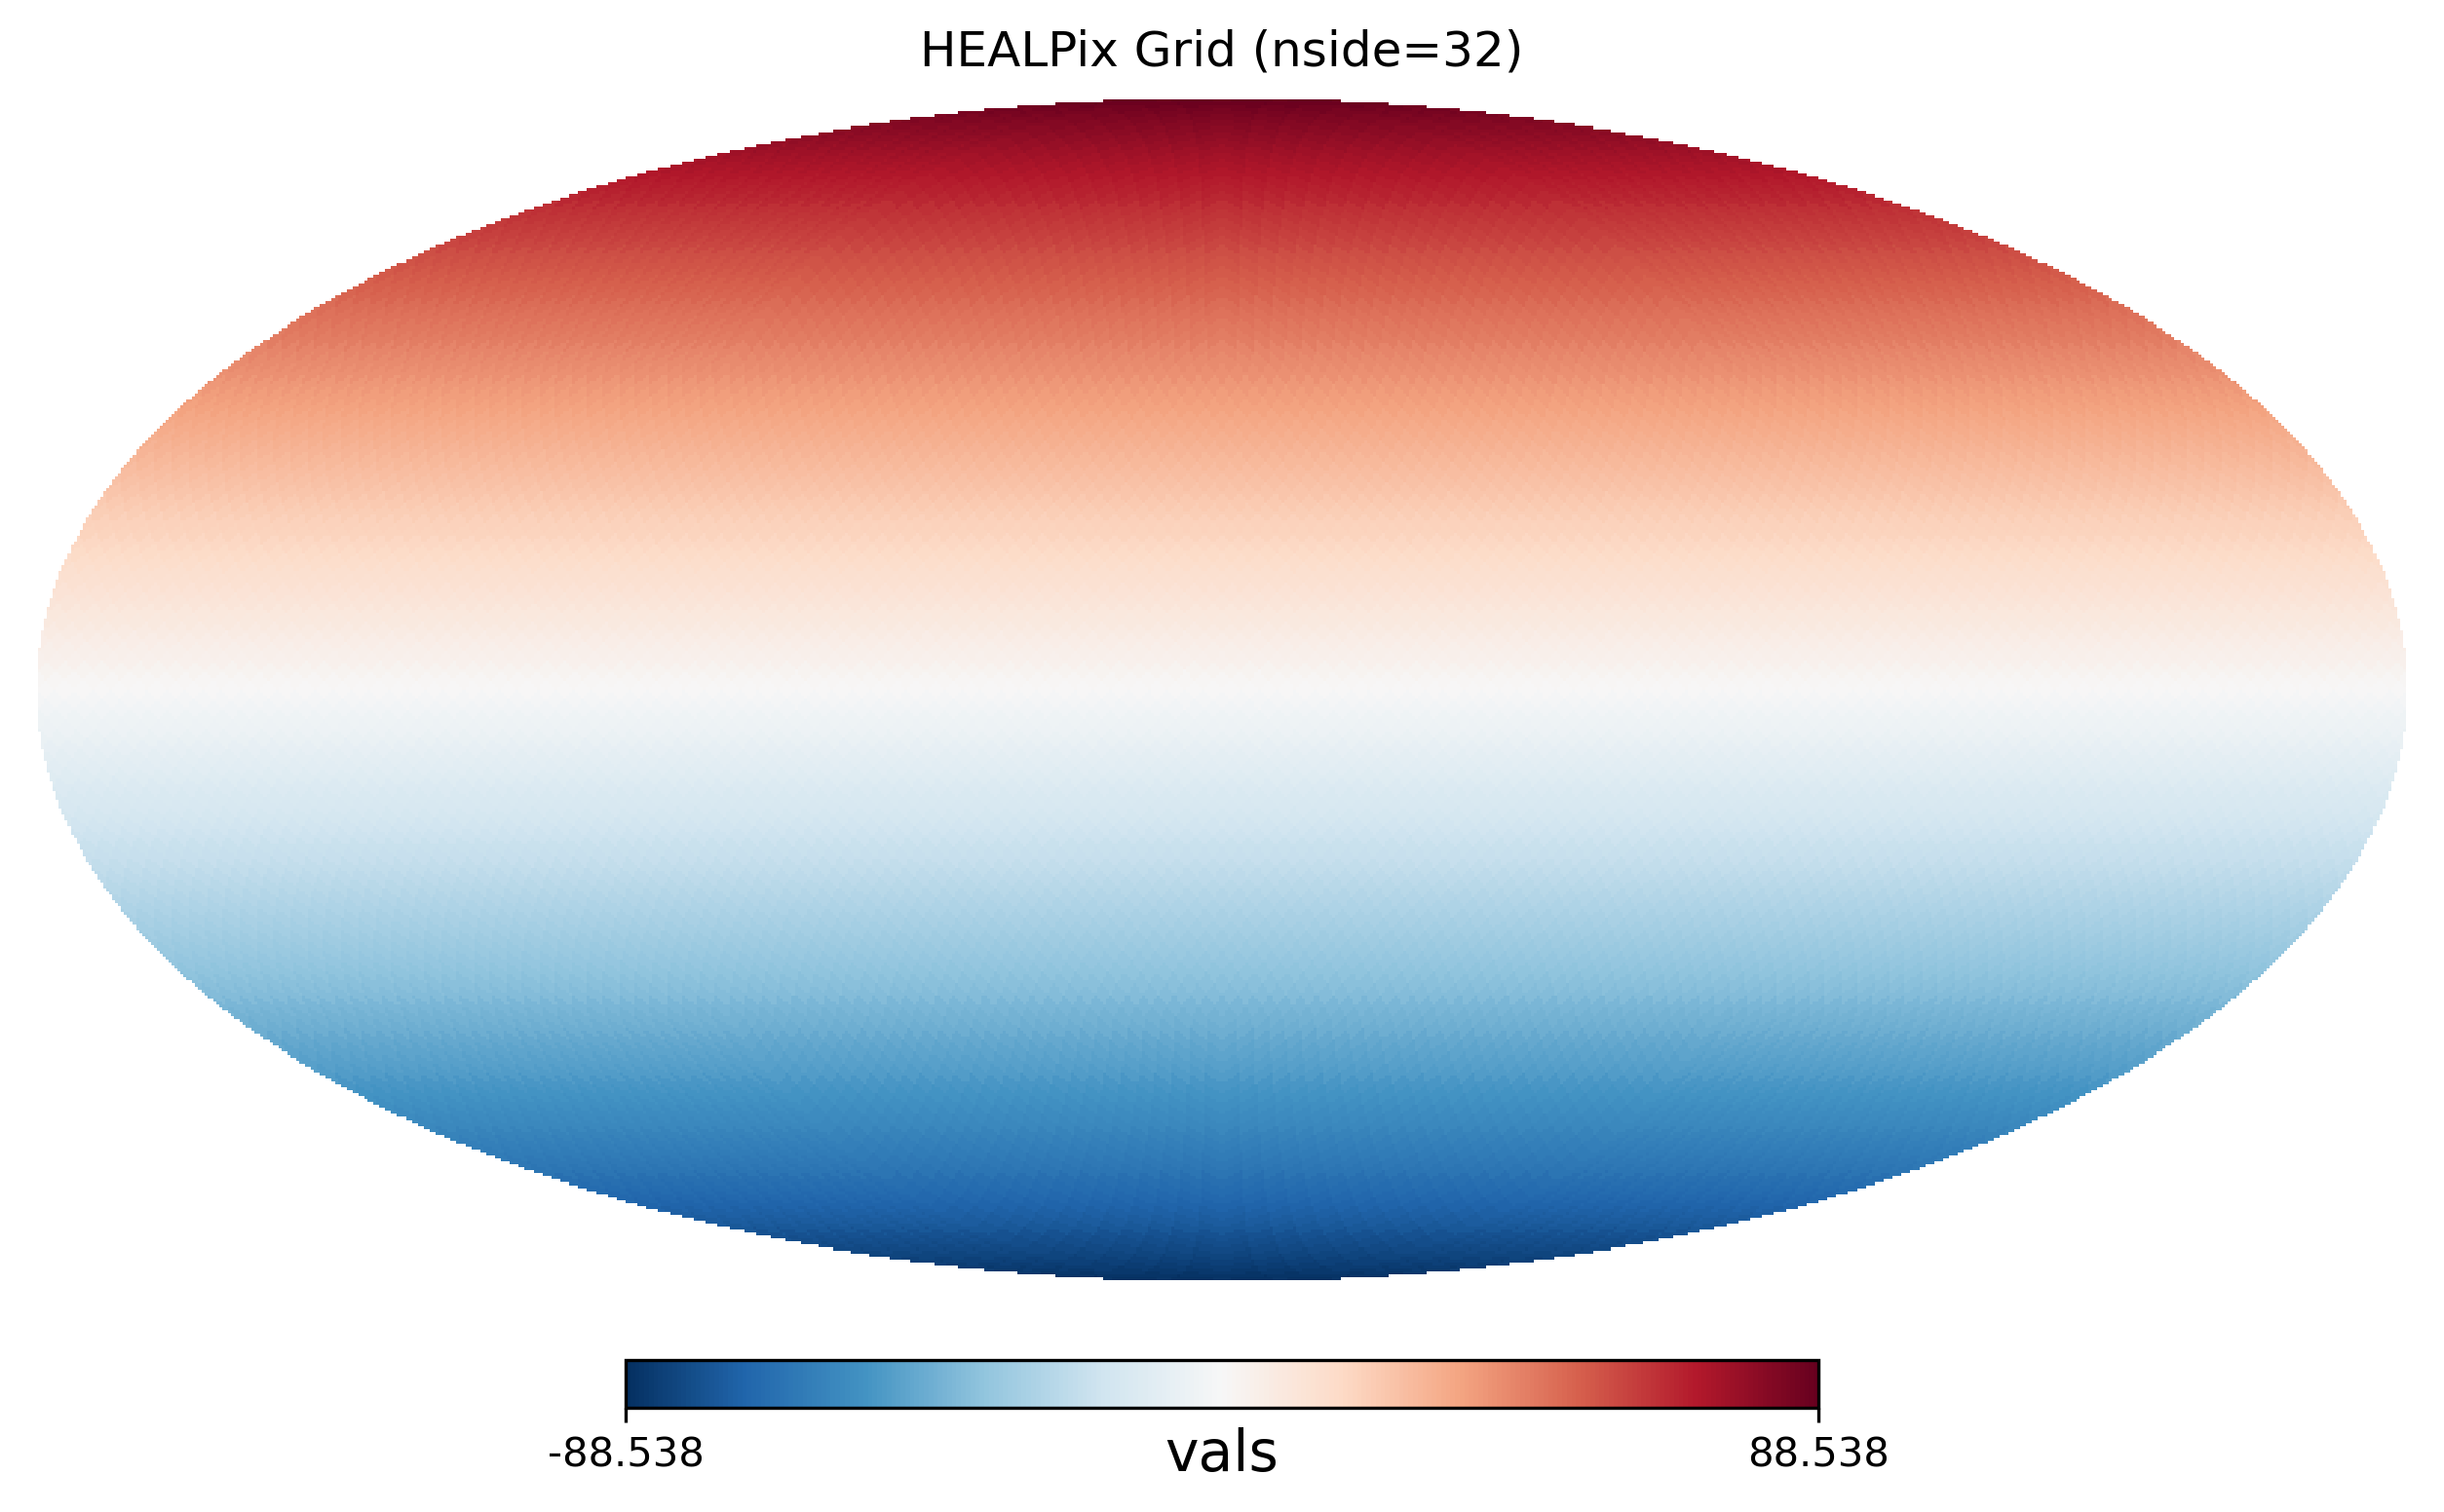

In [3]:
# HEALPix requires a parameter called nside, which must be a power of two.
# If you don't provide an nside when you initialize the HealPixRegridder,
# it will calculate automatically based on the spatial resolution of the data.

# The number of pixels in the HealPix grid is given by: 12 * nside ** 2

regridder = HealPixRegridder(nside=2)  # 12 * (2 ** 1) ** 2 = 48 pixels
regridder.demo_plot()

regridder = HealPixRegridder(nside=32)  # 12 * 32 ** 2 = 12,288 pixels
regridder.demo_plot()

In [4]:
# Regular latitude/longitude grids have denser sampling near the poles,
# which can bias clustering results. We'll use a regridder to convert
# the data to an equal-area grid (HEALPix) before clustering.
regridder = HealPixRegridder()
td.compute_clusters(
    "tas",
    shifts_filter_func=lambda x: np.abs(x) > 0.6,
    method=HDBSCAN(min_cluster_size=25),
    overwrite=True,
    regridder=regridder,
)
# Take 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('tas')}")

INFO: Automatically computed nside: 64
INFO: Applying clustering method HDBSCAN(min_cluster_size=25)


Identified clusters: [-1  1  0  2  3  4  5  6  7  8  9 10 11]


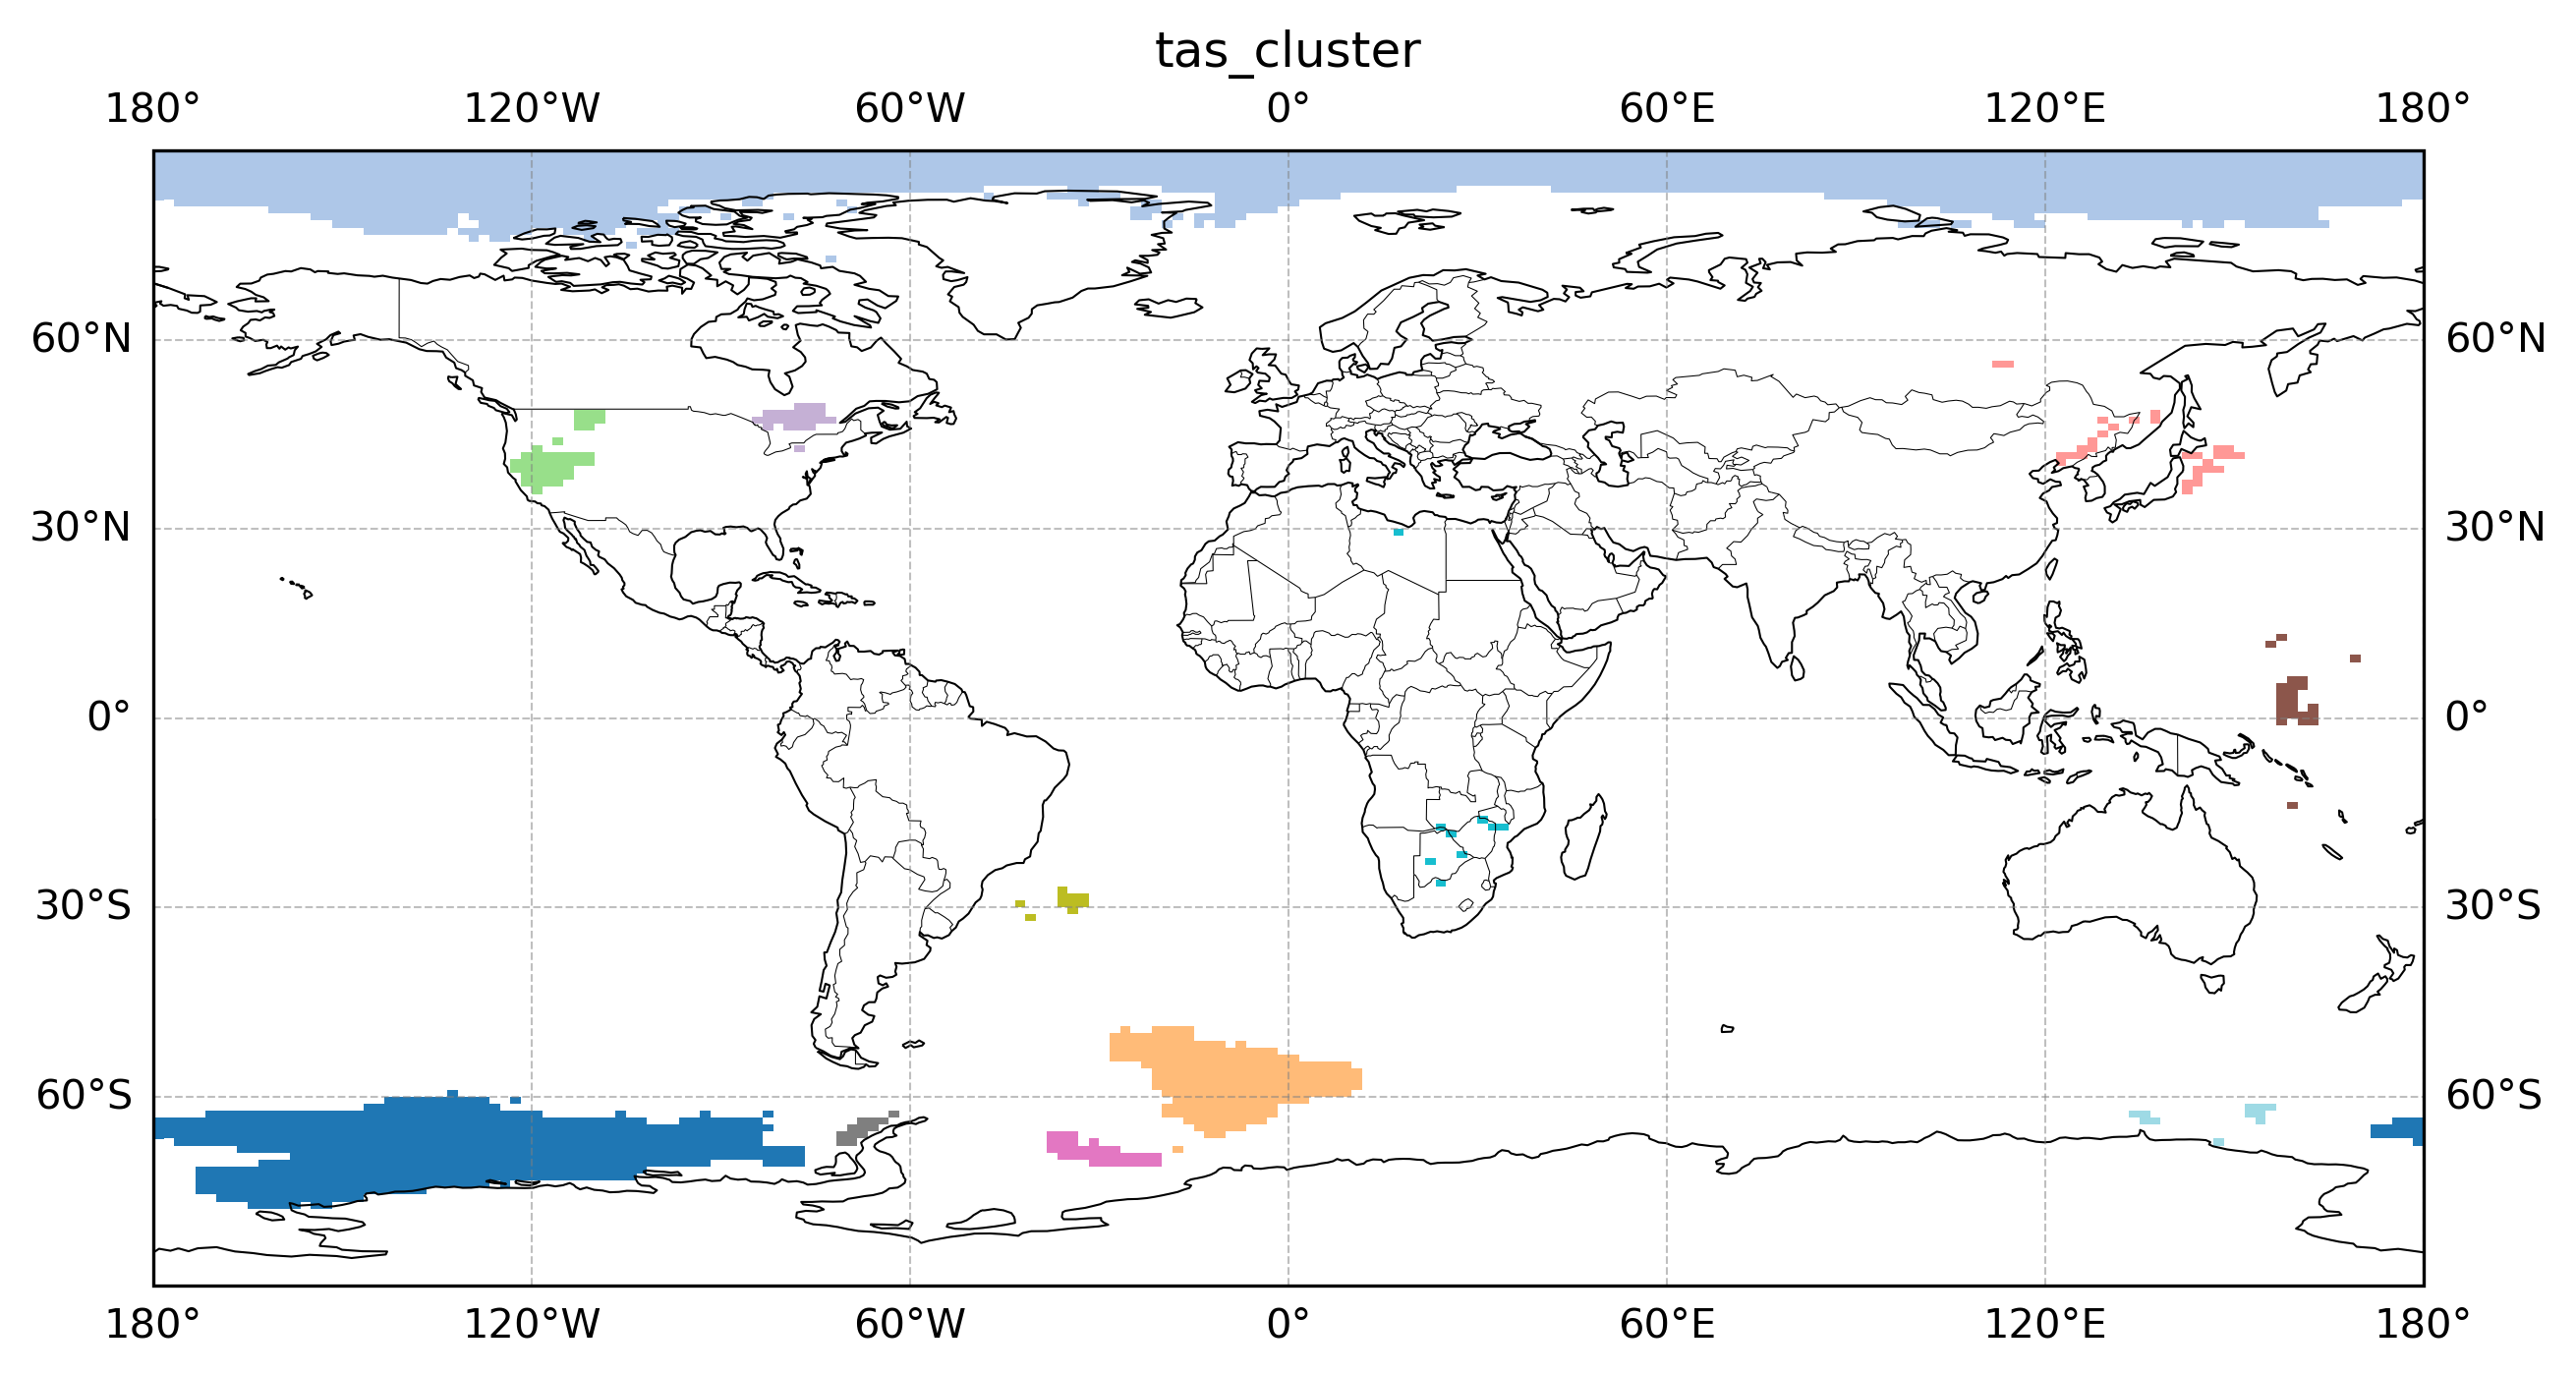

In [5]:
fig, ax = td.plotter().map_plots()
td.plotter().plot_clusters_on_map("tas", ax=ax);

In [6]:
# we can also access the clusters in the healpix grid
regridder.df_healpix

,time,hp_pix,vals,lat,lon,cluster
0,2020.0,36706,0.614583,-29.313199,317.812500,9
1,2020.0,46564,0.625000,-63.448284,191.250000,0
2,2020.0,46566,0.656250,-63.448284,196.250000,0
3,2020.0,46568,0.614583,-63.448284,201.250000,0
4,2020.0,46706,0.666667,-64.198746,191.571429,0
...,...,...,...,...,...,...
9836,2095.0,348,0.625000,80.486520,252.692308,1
9837,2095.0,524,0.656250,78.284148,250.312500,1
9838,2095.0,525,0.656250,78.284148,255.937500,1
9839,2095.0,591,0.604167,77.549098,251.470588,1


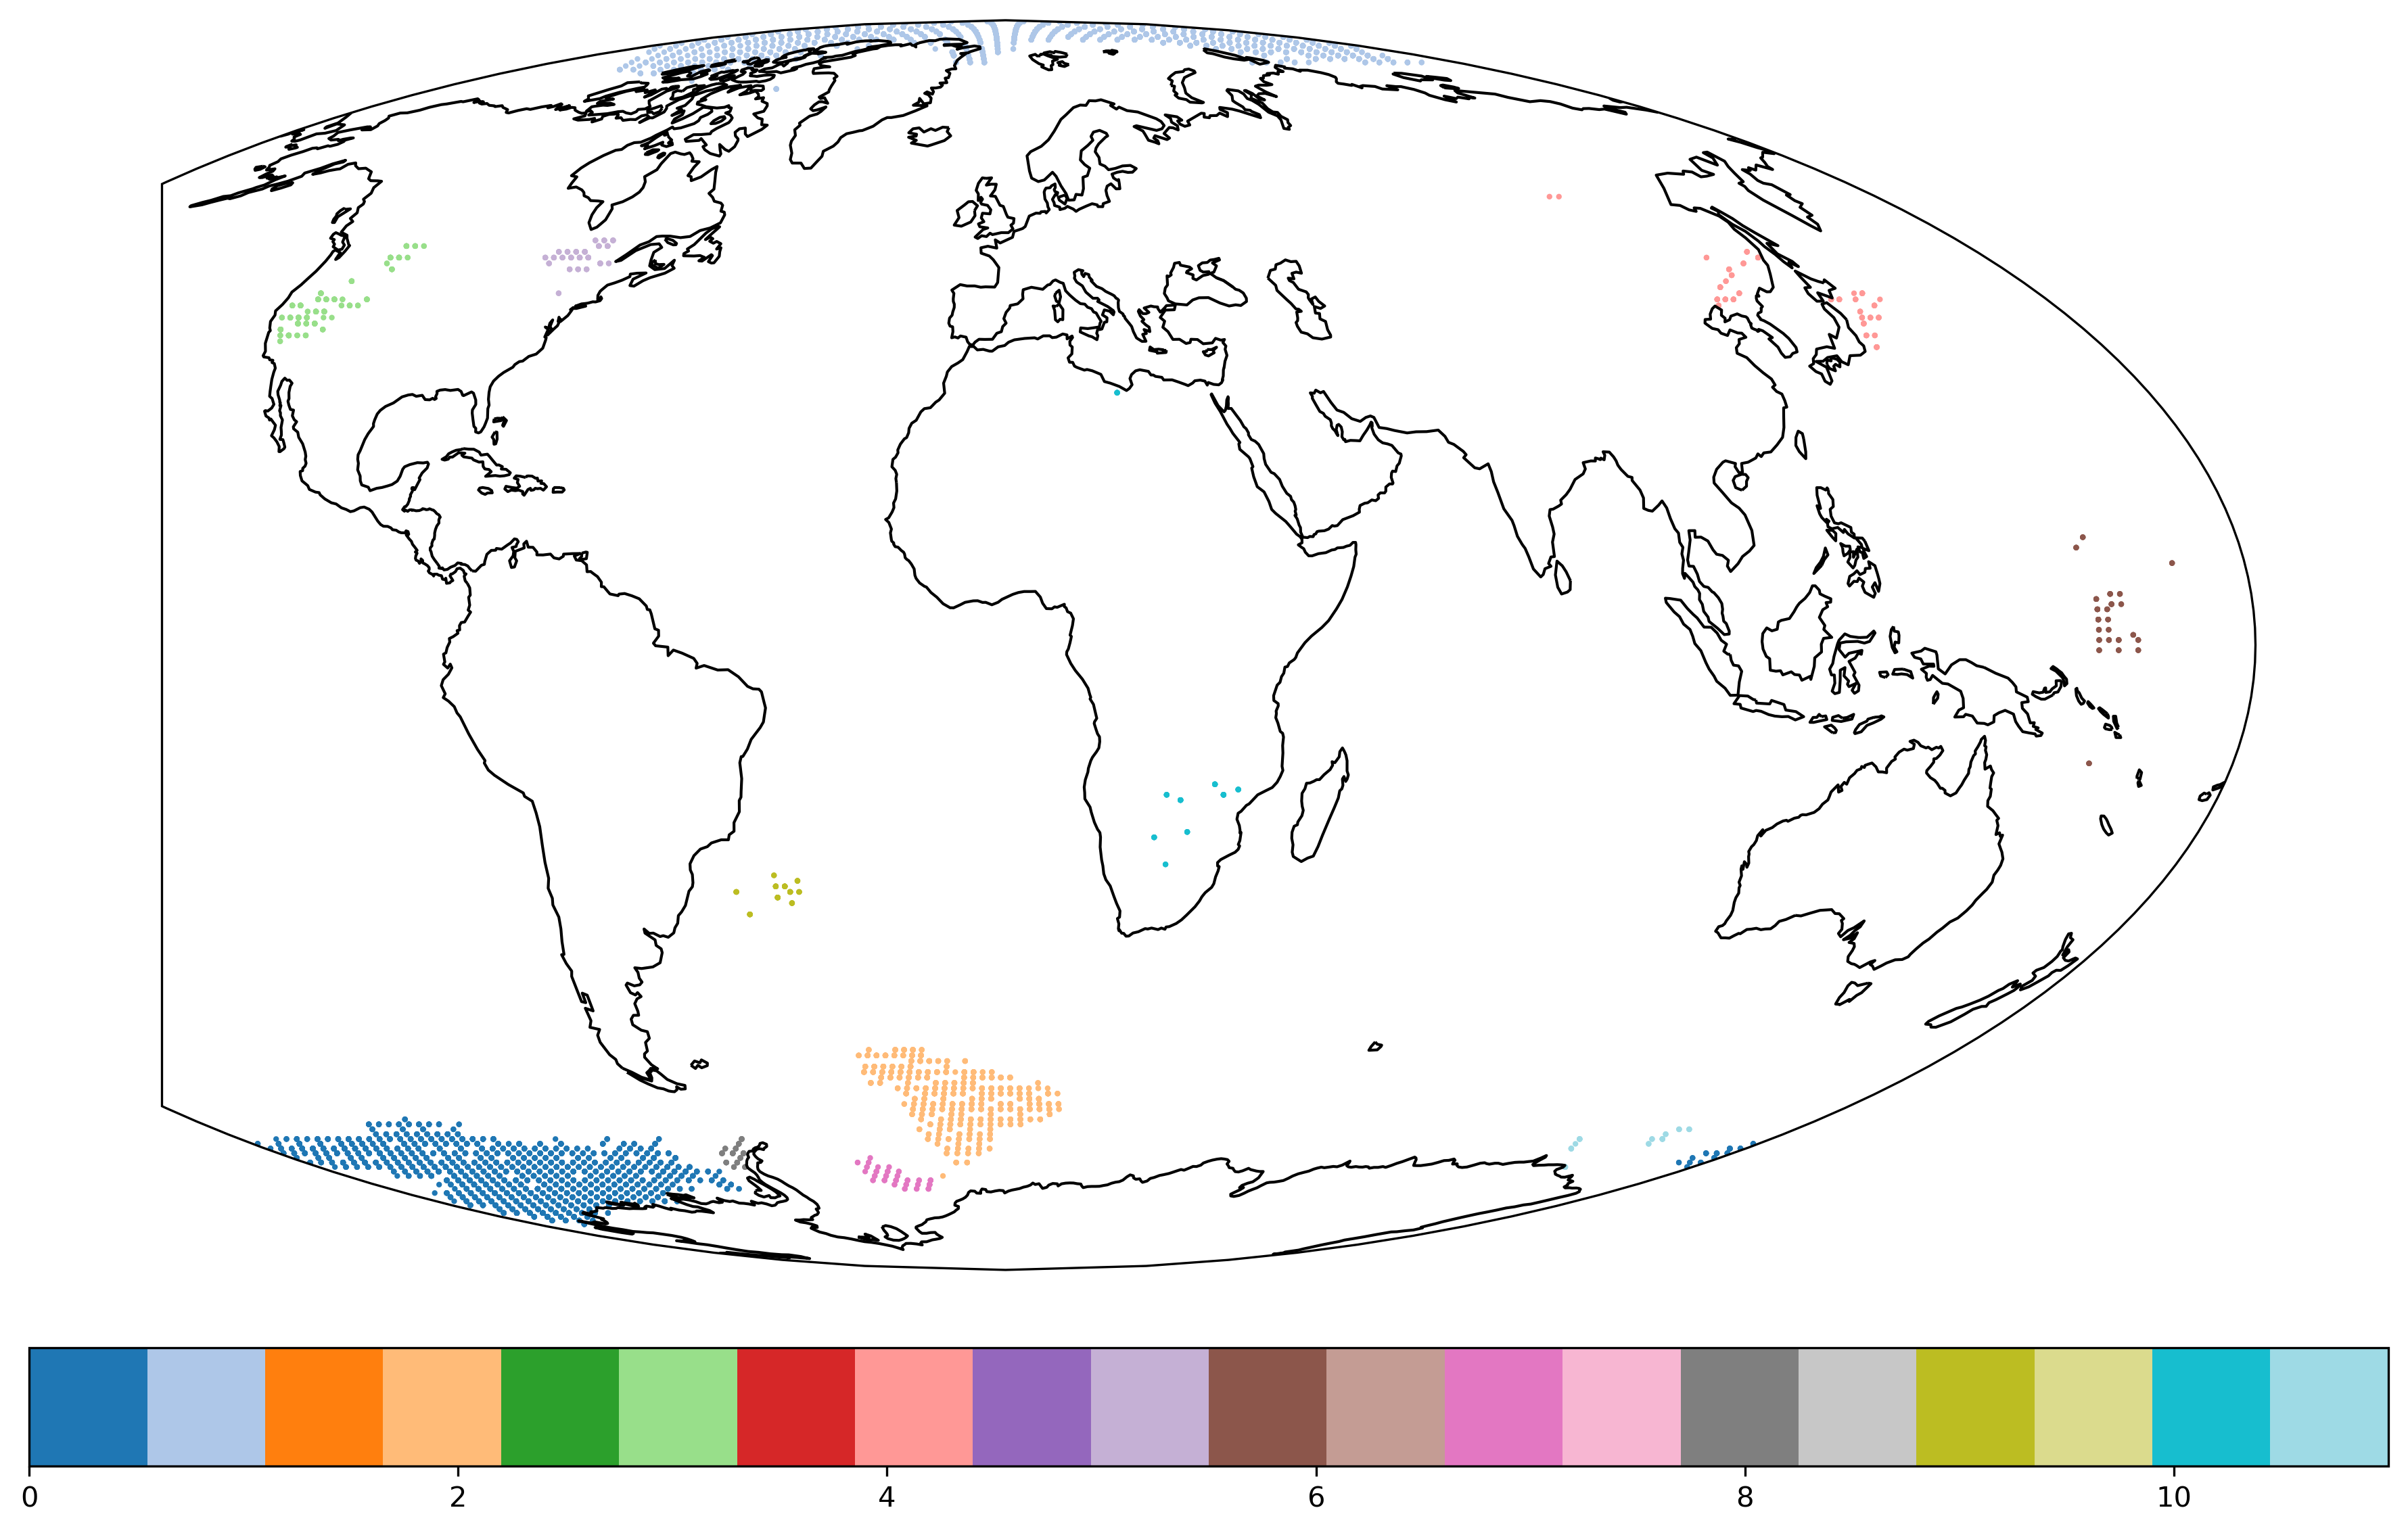

In [7]:
# or plot the data in the healpix grid
regridder.plot_clusters()